## Trajectory analysis template
General geometric trajectory analysis from a ```.mymridon``` experiment file to be saved as a csv, which can be further analyzed in the optional part or exported into other software such as RStudio. Operations like done here are typically heavy and python benefits from the effeciency of the underlying ```myrmidon``` library to a big extent, especially in combination with the ```numpy``` math library.
This notebook is a walk trough a sample usage of the following:
* the py-myrmidon library ([Documentation](https://formicidae-tracker.github.io/myrmidon/latest/))
* numpy quick start [tutorial](https://numpy.org/devdocs/user/quickstart.html)

In [1]:
import py_fort_myrmidon as fm
import numpy as np  # Fundamental math library in python. Here used only for convience: to save the csv.
from datetime import datetime, timedelta  # For convenient handling of time and date
import numpy as np  # Basic math library
import pandas as pd  # Used to create a dataframe, similar to the structure used in R
import matplotlib.pyplot as plt  # Optional: for plorring
# Optional: makes plots interactive:
%matplotlib widget

In [2]:
f_myrmidon = "/home/user/Documents/experiment_folder/exp.myrmidon"
exp = fm.Experiment.Open(f_myrmidon)
t_start = datetime(2021, 2, 18, 0, 1).astimezone(tz=None)  # <year, month, day, hour, minute>
t_end = datetime(2021, 2, 18, 1, 0).astimezone(tz=None)

The following is an iterator for fort mymrmidon time over days in a period. See Ant metadata template for explanation.

In [3]:
def fm_time_range(start_datetime, end_datetime):
    for n in range(int((end_datetime - start_datetime).days) + 1):
        yield fm.Time(start_datetime + timedelta(n))

Calculate the mean speed in pixels/second of each ant during the period (```t_start```, ```t_end```). This can serve as measure for the activity of the individual during that period. If the ```maximumGap``` is set to a period larger than (```t_start```, ```t_end```), then every ```ant_id``` will have at most one trajectory which makes the analysis easier in this case. The meaning of the positions in a trajectory are described [here](https://formicidae-tracker.github.io/myrmidon/latest/api/python/queries_matchers.html#py_fort_myrmidon.AntTrajectory.Positions). Another option would be to calculate the angular speed.

In [4]:
df_trajectory_stats = pd.DataFrame(index=exp.Ants)
df_trajectory_stats["speed_mean"] = np.nan
df_trajectory_stats["speed_std"] = np.nan
for t_begin in fm_time_range(t_start, t_end):
    trajectories = fm.Query.ComputeAntTrajectories(experiment=exp,
                                                   start=t_begin,
                                                   end=t_begin.Add(fm.Duration.Parse('24h')),
                                                   maximumGap=fm.Duration.Parse('1000h'))
    for t in trajectories:
        dxdy = np.diff(t.Positions[:,1:3], axis=0)  # x-y differerence between detections (2d vector)
        ds = np.linalg.norm(dxdy, axis=1)  # displacement between detections (1d vector)
        dt = np.diff(t.Positions[:,0])  # Time interval between detections (1d vector)
        speed = np.divide(ds, dt, where=dt>0)  # [pixels / second]  (zero dt gaps are quite rare but can occur)
        df_trajectory_stats.loc[t.Ant, "speed_mean"] = np.mean(speed)
        df_trajectory_stats.loc[t.Ant, "speed_std"] = np.std(speed)

Save dataframe to a csv and optionally show and plot the results.

In [5]:
f_name = "ant_trajectory_stats_{}_{}_{}.csv".format(exp.Name, t_start, t_end)
df_trajectory_stats.to_csv(f_name, index_label='ant_id')

|    |   speed_mean |   speed_std |
|---:|-------------:|------------:|
|  1 |     37.1369  |     92.9128 |
|  2 |      7.41075 |     22.0812 |
|  3 |    nan       |    nan      |
|  4 |    236.356   |    220.418  |
|  5 |      8.89072 |     25.8877 |
|  6 |    nan       |    nan      |
|  7 |     16.8424  |     43.2587 |
|  8 |      8.38602 |     21.8534 |
|  9 |     15.4717  |     45.2661 |
| 10 |      9.56718 |     26.3502 |


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
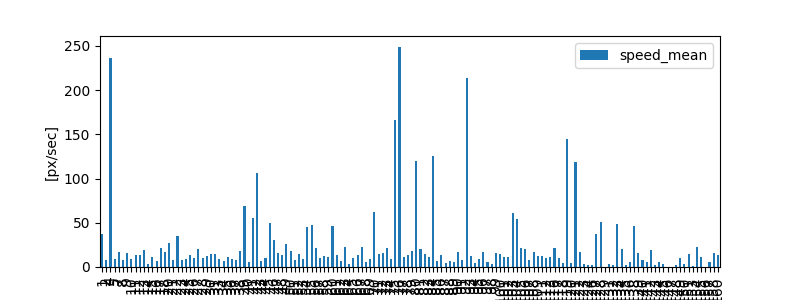

In [6]:
df_trajectory_stats.pivot_table(values='speed_mean', index=df_trajectory_stats.index).plot(kind='bar', figsize=(8,3), ylabel="[px/sec]")
print(df_trajectory_stats[:10].to_markdown()) 